In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from py_vollib_vectorized import vectorized_implied_volatility as implied_vol
# Parameters
# simulation dependent
S0 = 100.0             # asset price
T = 1.0                # time in years
r = 0.02               # risk-free rate
N = 252                # number of time steps in simulation
M = 30               # number of simulations

# Heston dependent parameters
kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2           # initial variance under risk-neutral dynamics
rho = 0.7              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.6            # volatility of volatility

In [22]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
    """
    Inputs:
     - S0, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - T     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations
    
    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    """
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)

    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))

    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
    
    return S, v

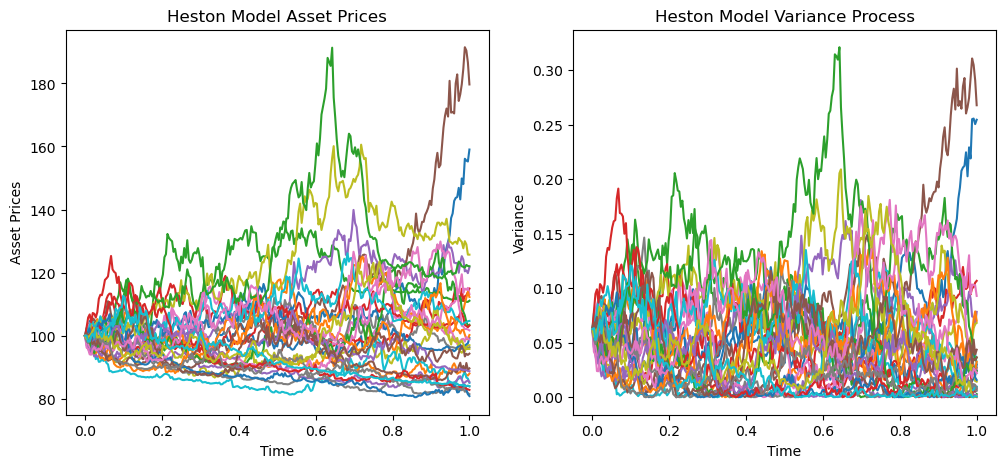

In [23]:
rho_p = 0.98
rho_n = -0.98
S_p,v_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma,T, N, M)
S_n,v_n = heston_model_sim(S0, v0, rho_n, kappa, theta, sigma,T, N, M)
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,N+1)
ax1.plot(time,S_p)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

ax2.plot(time,v_p)
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')

plt.show()

/Users/anthony/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/anthony/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/anthony/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


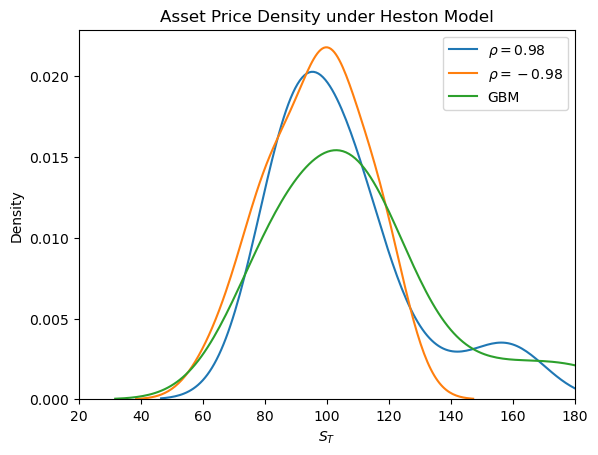

In [19]:
# simulate gbm process at time T
gbm = S0*np.exp( (r - theta**2/2)*T + np.sqrt(theta)*np.sqrt(T)*np.random.normal(0,1,M) )

fig, ax = plt.subplots()

ax = sns.kdeplot(S_p[-1], label=r"$\rho= 0.98$", ax=ax)
ax = sns.kdeplot(S_n[-1], label=r"$\rho= -0.98$", ax=ax)
ax = sns.kdeplot(gbm, label="GBM", ax=ax)

plt.title(r'Asset Price Density under Heston Model')
plt.xlim([20, 180])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.show()

In [20]:
rho = -0.7
S,v = heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M)

# Set strikes and complete MC option price for different strikes
K = np.arange(20,180,2)

puts = np.array([np.exp(-r*T)*np.mean(np.maximum(k-S,0)) for k in K])
calls = np.array([np.exp(-r*T)*np.mean(np.maximum(S-k,0)) for k in K])

put_ivs = implied_vol(puts, S0, K, T, r, flag='p', q=0, return_as='numpy', on_error='ignore')
call_ivs = implied_vol(calls, S0, K, T, r, flag='c', q=0, return_as='numpy')

plt.plot(K, call_ivs, label=r'IV calls')
plt.plot(K, put_ivs, label=r'IV puts')

plt.ylabel('Implied Volatility')
plt.xlabel('Strike')

plt.title('Implied Volatility Smile from Heston Model')
plt.legend()
plt.show()

NameError: name 'implied_vol' is not defined